# 1. Importing the necessary libraries 

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from PIL import Image,ImageEnhance 

from skimage.io import imread
import os, random, pathlib, warnings, itertools, math
warnings.filterwarnings("ignore")

import gc
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

import plotly.express as px
from pathlib import Path
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix



# 2. Loading the train and valid datasets

I) Getting the image datasets paths.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_dir='/content/drive/MyDrive/Veg/Vegetable Images/train'
valid_dir ='/content/drive/MyDrive/Veg/Vegetable Images/test'

II) From the following code we can identify the image datasets per class. As, there are 15 classes and each class has 200 images.  

In [4]:
def count_files(rootdir):
    '''counts the number of files in each subfolder in a directory'''
    for path in pathlib.Path(rootdir).iterdir():
        if path.is_dir():
            print("There are " + str(len([name for name in os.listdir(path) \
            if os.path.isfile(os.path.join(path, name))])) + " files in " + \
            str(path.name))
 
count_files(os.path.join(valid_dir))

There are 200 files in Tomato
There are 200 files in Radish
There are 200 files in Cucumber
There are 200 files in Potato
There are 200 files in Cauliflower
There are 200 files in Pumpkin
There are 200 files in Papaya
There are 200 files in Broccoli
There are 200 files in Cabbage
There are 200 files in Capsicum
There are 200 files in Carrot
There are 200 files in Brinjal
There are 200 files in Bitter_Gourd
There are 200 files in Bottle_Gourd
There are 200 files in Bean


III)There are 15000 images belonging to the train datasets and 3000 images belonging to the test datsets. Now, loading the training and validation image datasets also applying the augmentations on it.

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size = 36,
                                                   class_mode = 'categorical',
#                                                    color_mode='grayscale',
                                                   shuffle= True,
                                                   target_size=(150,150))

Found 15000 images belonging to 15 classes.


In [6]:
valid_datagen = ImageDataGenerator(rescale=1.0/255)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                   batch_size= 36,
                                                   class_mode='categorical',
#                                                    color_mode='grayscale',
                                                   shuffle= True,
                                                   target_size=(150,150))

Found 3000 images belonging to 15 classes.


Here, the preprocessing of the images is done by enchancing the existing images also by changing its contrast and sharpness level. The resizing is done above which is also the part of data augmentation.

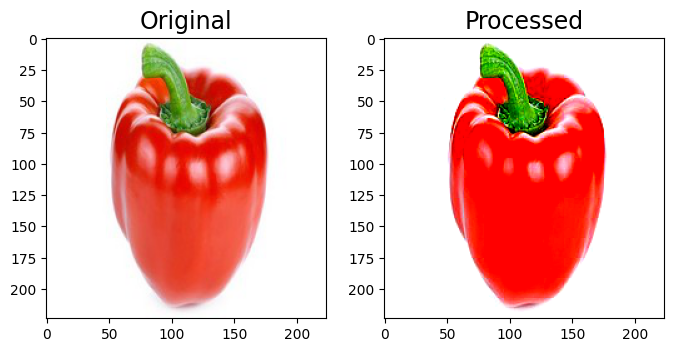

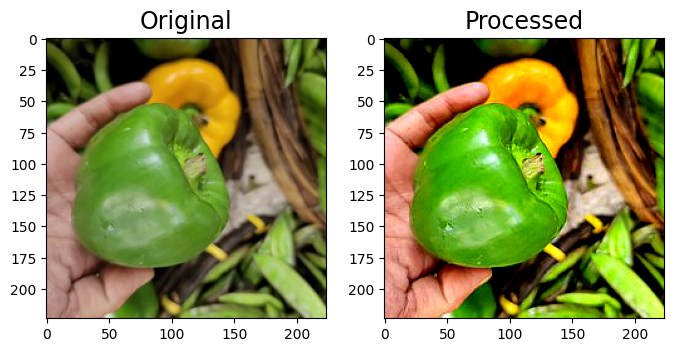

In [7]:
image_folder="Capsicum"  # The vegetable you want to display
number_of_images=2       # Number of images to display

def Preprocess():
    j=1
    for i in range(number_of_images):
    
        folder = os.path.join(valid_dir,image_folder)
        a= random.choice(os.listdir(folder))

        image=Image.open(os.path.join(folder,a))
        image_duplicate=image.copy()
        plt.figure(figsize=(8,8))

        plt.subplot(number_of_images,2,j)
        plt.title(label='Original', size=17, pad='7.0', loc="center", fontstyle='normal')
        plt.imshow(image)
        j+=1

        image1=ImageEnhance.Color(image_duplicate).enhance(1.35)
        image1=ImageEnhance.Contrast(image1).enhance(1.45)
        image1=ImageEnhance.Sharpness(image1).enhance(2.5)
        
        plt.subplot(number_of_images,2,j)
        plt.title(label='Processed', size=17, pad='7.0', loc="center", fontstyle='normal')
        plt.imshow(image1)
        j+=1
        
Preprocess()

# 3. Getting the label mappings  

For the image datasets the labelling is done by the indexing each image datasets so that it can be used in the following process which can be in the confusion matrix as well. While the name of each vegetable could be named after the number and the numbering can be used.

In [8]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Bean
1 : Bitter_Gourd
2 : Bottle_Gourd
3 : Brinjal
4 : Broccoli
5 : Cabbage
6 : Capsicum
7 : Carrot
8 : Cauliflower
9 : Cucumber
10 : Papaya
11 : Potato
12 : Pumpkin
13 : Radish
14 : Tomato


# 4. Displaying the sample of training datasets

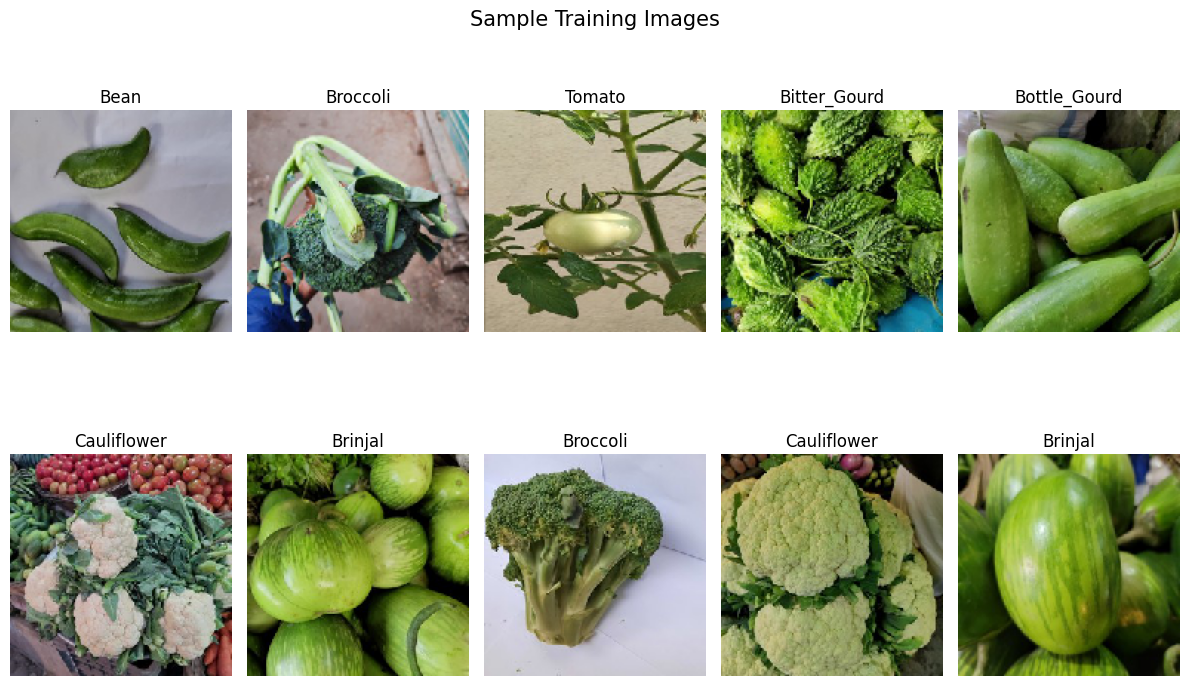

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 8))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=15)
plt.show()

# 5. Creating the Convolutional Neural Network


For training our model first of all we need to create a cnn model. The following code represents the cnn model which uses convolutional layers to train the image datasets.The conv2d is used to represent the node of the convolutional layers where the forward propagation and backpropagation is used to calculate the accuracy and loss of the model.
MaxPooling2d usually takes the number of blocks and picks the maximum number of pixels containing blocks. While the Dense is the output layer.
Generally in the multi classification process the most used activation function is softmax.It transforms the ouput to the vector probabilities. Relu is used in the input layer for stopping the vanishing of gradient problem while softmax is used in the output layer for firing the neuron.




In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(15,activation='softmax')
])

In [11]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
             optimizer= tf.keras.optimizers.Adam(learning_rate=0.01),
             metrics=['acc'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 dense (Dense)               (None, 34, 34, 32)        2

In [13]:
history = model.fit(train_generator,epochs=8,
                validation_data=valid_generator,validation_steps=26)

Epoch 1/8
417/417 [==============================] - 2457s 6s/step - loss: 3.6702 - acc: 0.0669 - val_loss: 2.7082 - val_acc: 0.0641
Epoch 2/8
417/417 [==============================] - 178s 427ms/step - loss: 2.7101 - acc: 0.0644 - val_loss: 2.7088 - val_acc: 0.0641
Epoch 3/8
417/417 [==============================] - 138s 330ms/step - loss: 2.7101 - acc: 0.0647 - val_loss: 2.7084 - val_acc: 0.0620
Epoch 4/8
417/417 [==============================] - 109s 261ms/step - loss: 2.7099 - acc: 0.0638 - val_loss: 2.7082 - val_acc: 0.0769
Epoch 5/8
417/417 [==============================] - 91s 218ms/step - loss: 2.7098 - acc: 0.0639 - val_loss: 2.7098 - val_acc: 0.0588
Epoch 6/8
417/417 [==============================] - 91s 218ms/step - loss: 2.7100 - acc: 0.0633 - val_loss: 2.7079 - val_acc: 0.0630
Epoch 7/8
417/417 [==============================] - 70s 167ms/step - loss: 2.7096 - acc: 0.0671 - val_loss: 2.7098 - val_acc: 0.0588
Epoch 8/8
417/417 [==============================] - 66s 158

In [23]:
 model.save('predict.h1')

In [24]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']

train_loss = history.history['loss']
val_loss = history.history['val_loss']


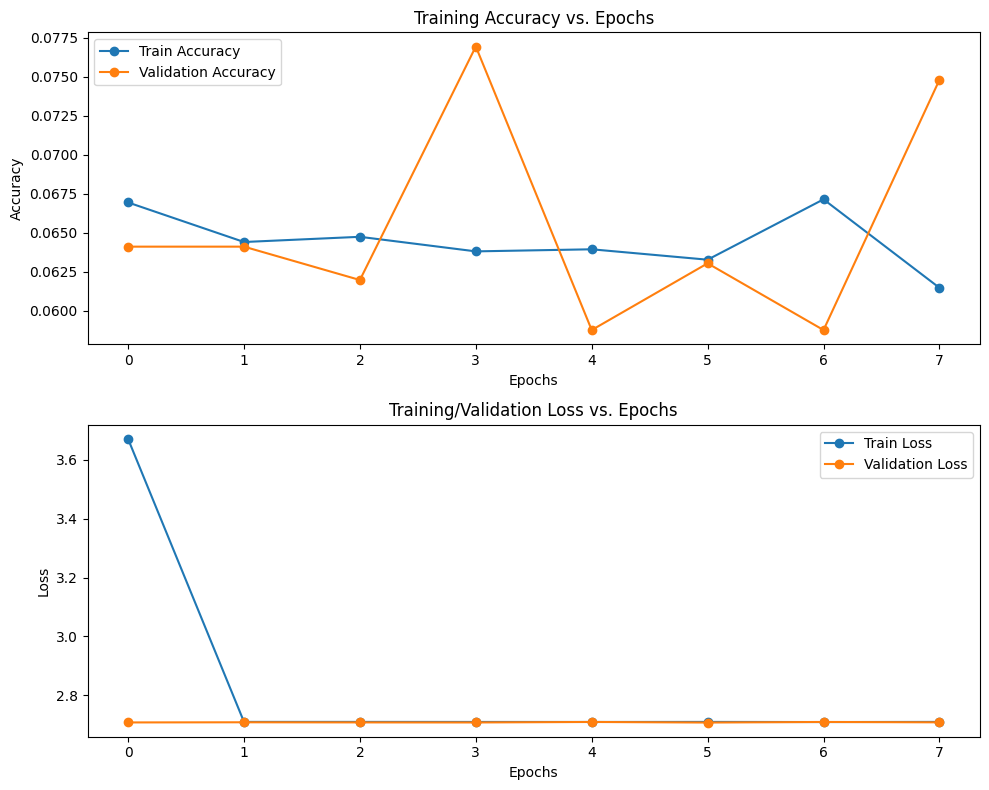

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_acc, 'o-', label='Train Accuracy')
ax[0].plot(val_acc, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [26]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']

train_loss = history.history['loss']
val_loss = history.history['val_loss']


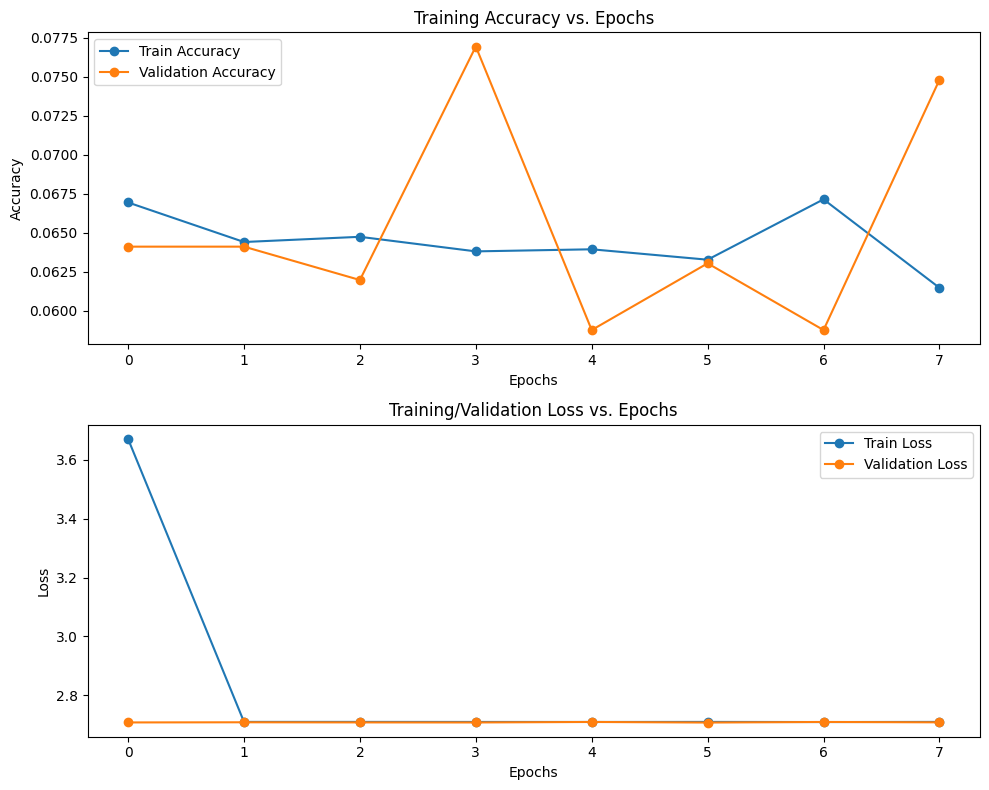

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_acc, 'o-', label='Train Accuracy')
ax[0].plot(val_acc, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

# ax[2].set_title('Learning Rate vs. Epochs')
# ax[2].plot(learning_rate, 'o-', label='Learning Rate')
# ax[2].set_xlabel('Epochs')
# ax[2].set_ylabel('Loss')
# ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

In [28]:
new_model = tf.keras.models.load_model('predict.h1')

In [30]:
valid_dir = '/content/drive/MyDrive/Veg/Vegetable Images/test'

scores = model.evaluate_generator(valid_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Test Accuracy: 0.067


In [36]:
category={
    0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3 : 'Brinjal', 4: "Broccoli", 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower',
    9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13 : "Radish", 14: "Tomato"
}

def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(150, 150))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(150, 150))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {original}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,original=true))


1/1 [==============================] - 0s 251ms/step


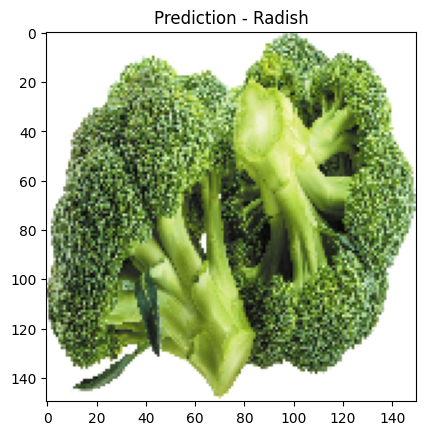

In [37]:
predict_image(os.path.join('/content/drive/MyDrive/Veg/bro.jpg'),model)

In [38]:
IMAGE_SIZE = [150, 150]

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(15, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

87910968/87910968 [==============================] - 1s 0us/step


In [39]:
train_datagen = image.ImageDataGenerator(rescale = 1./255,
                                         shear_range = 0.2,
                                         zoom_range = 0.2,
                                         horizontal_flip = True)

valid_datagen = image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 100,
    class_mode = 'categorical')

test_set = valid_datagen.flow_from_directory(
    valid_dir, 
    target_size = (150, 150),
    batch_size = 100, 
    class_mode = 'categorical')

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [40]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=3,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/3
150/150 [==============================] - 148s 937ms/step - loss: 0.4923 - accuracy: 0.8575 - val_loss: 0.0978 - val_accuracy: 0.9720
Epoch 2/3
150/150 [==============================] - 143s 952ms/step - loss: 0.1368 - accuracy: 0.9564 - val_loss: 0.0752 - val_accuracy: 0.9790
Epoch 3/3
150/150 [==============================] - 125s 834ms/step - loss: 0.0989 - accuracy: 0.9669 - val_loss: 0.0495 - val_accuracy: 0.9847


In [41]:
model.save('model_inceptionV3.h5')

In [42]:
model = tf.keras.models.load_model('model_inceptionV3.h5')

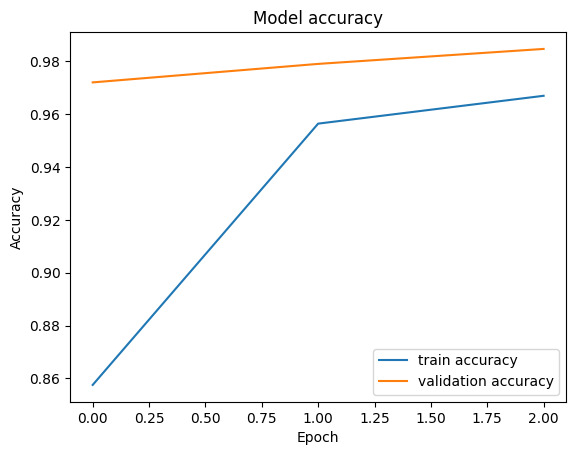

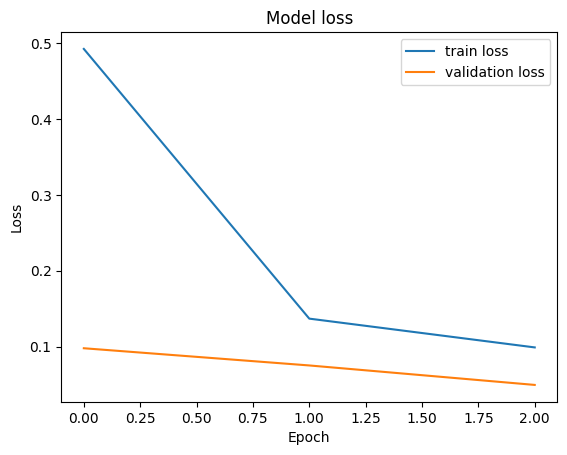

In [43]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(r)
plot_loss(r)

In [44]:
valid_dir = '/content/drive/MyDrive/Veg/Vegetable Images/test'

scores = model.evaluate_generator(valid_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Test Accuracy: 0.985


In [45]:
category={
    0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3 : 'Brinjal', 4: "Broccoli", 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower',
    9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13 : "Radish", 14: "Tomato"
}

def predict_image(filename, model):
    img_ = image.load_img(filename, target_size=(150, 150))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(150, 150))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {original}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,original=true))


1/1 [==============================] - 2s 2s/step


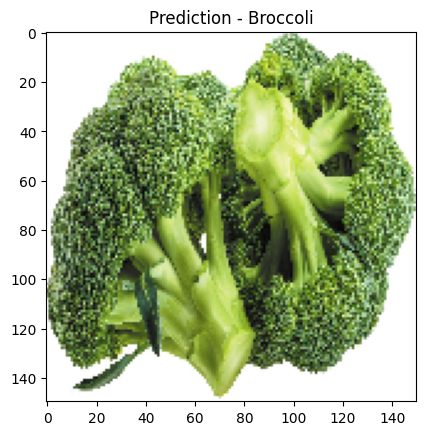

In [46]:
predict_image(os.path.join('/content/drive/MyDrive/Veg/bro.jpg'),model)

1/1 [==============================] - 0s 26ms/step


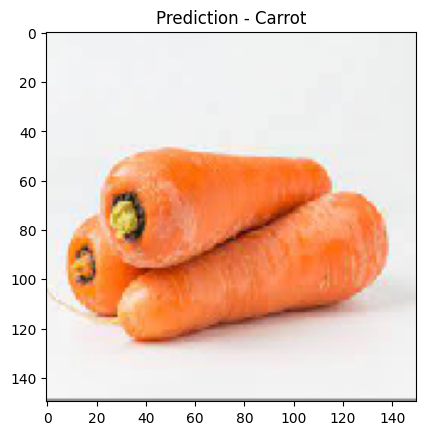

In [47]:
predict_image(os.path.join('/content/drive/MyDrive/Veg/carrot.jpg'),model)

In [48]:
probabilities = model.predict_generator(test_set)
y_pred = np.argmax(probabilities, axis=1)

print(confusion_matrix(test_set.classes, y_pred))

[[17  6 18 13 14 18 12 13  9  9 15 17 11 12 16]
 [16 13 10 20 17 12 12 14 14  7 16 14 15  9 11]
 [16 17 11 12 12 14  8 16 12 21 13 12 14 12 10]
 [11 14 19 17  8 12 14 11 11 14 15 10 17  9 18]
 [14 18 16 13 15 12 12 12 22 11 13 13  9  9 11]
 [ 3 22 15 20  9  7 13  8 14 17 11 13 16 19 13]
 [15  9 14 16 15  7 12 14 12 11 15 18 12 16 14]
 [10 15 12 18 19 13 15 16 10  6 12 13 12 17 12]
 [12 11 15  7 13 21 21 14 10 10 12 14 15 11 14]
 [11 12 15 12 13 18 12 15 12 16 15 15 14  9 11]
 [13  8 10 13 17 17 21  9 14 15 13 14 12 14 10]
 [18 11 13 12  9 14 10 17 18 17 11  8 12 13 17]
 [17 11 12 10 21 15 12  7 16 17 16  9 14 10 13]
 [12 18  8 14 13 12 13 11 11 12 10 17 10 23 16]
 [12 13 14  9  7  7 12 19 12 14 17 14 18 18 14]]


<Axes: >

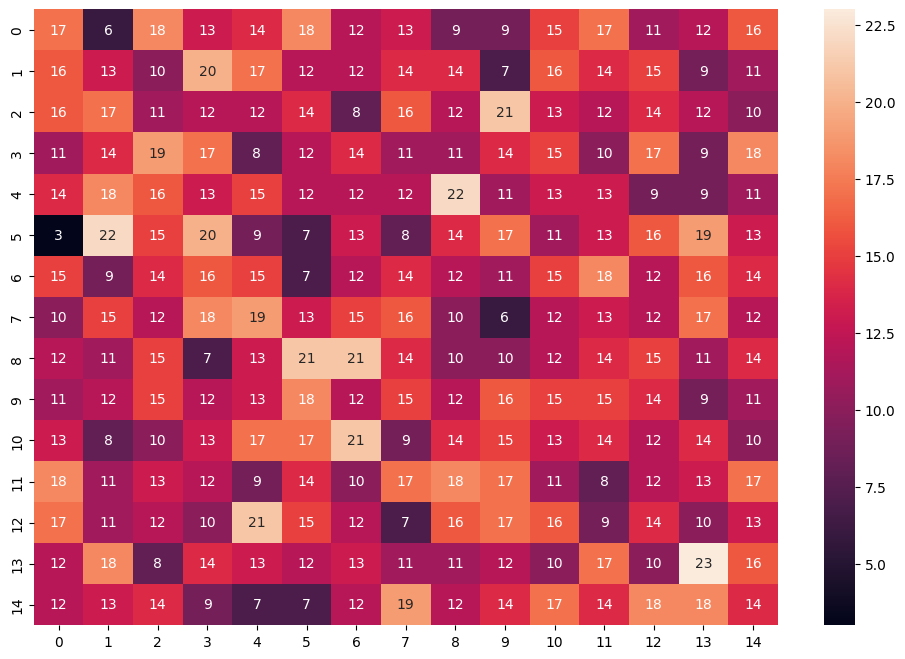

In [49]:
cf_matrix = confusion_matrix(test_set.classes, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cf_matrix, annot=True)

In [50]:
print(classification_report(test_set.classes, y_pred))

              precision    recall  f1-score   support

           0       0.09      0.09      0.09       200
           1       0.07      0.07      0.07       200
           2       0.05      0.06      0.05       200
           3       0.08      0.09      0.08       200
           4       0.07      0.07      0.07       200
           5       0.04      0.04      0.04       200
           6       0.06      0.06      0.06       200
           7       0.08      0.08      0.08       200
           8       0.05      0.05      0.05       200
           9       0.08      0.08      0.08       200
          10       0.06      0.07      0.06       200
          11       0.04      0.04      0.04       200
          12       0.07      0.07      0.07       200
          13       0.11      0.12      0.11       200
          14       0.07      0.07      0.07       200

    accuracy                           0.07      3000
   macro avg       0.07      0.07      0.07      3000
weighted avg       0.07   